=== TYPE별 날씨 민감도 (상위 15개: TEMP 기준) ===
      TYPE      N  TEMP_CORR(UNIT,TEMP)  RAIN_CORR(UNIT,RAIN)
   음식배달서비스   6891              0.032174              0.027924
      유흥주점  30102              0.016124              0.001153
    일식/수산물  78150             -0.009535              0.000709
    닭/오리요리  82195             -0.010530              0.005003
     패스트푸드  83166             -0.011702              0.006776
        분식  89882             -0.013062              0.000042
        양식  48537             -0.013237             -0.000289
        부페  33490             -0.013912             -0.002199
      간이주점  79528             -0.022413              0.011171
   별식/퓨전요리  79618             -0.031059              0.004244
        중식  73650             -0.039896             -0.001173
      고기요리  84140             -0.041354              0.001212
     커피/음료 101513             -0.044930              0.000601
제과/제빵/떡/케익  92250             -0.053461             -0.007911
  휴게소/대형업체   9812             -

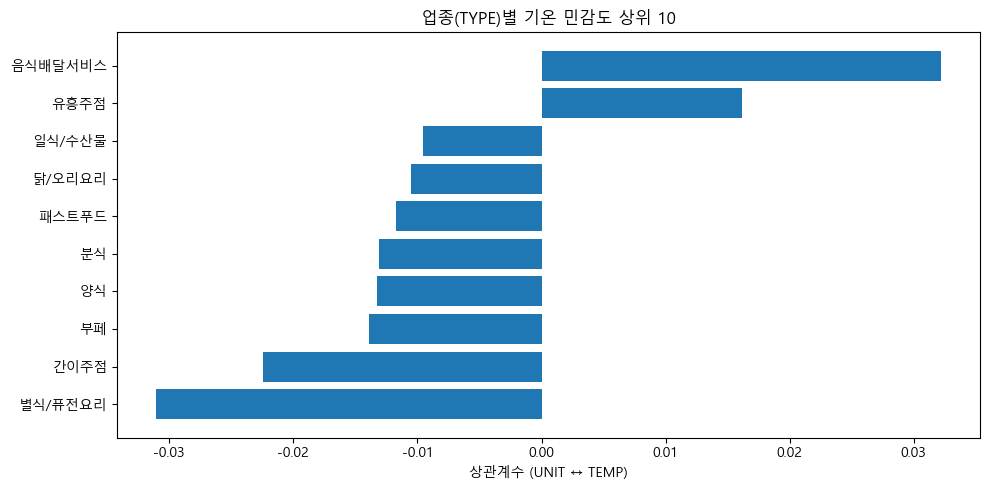

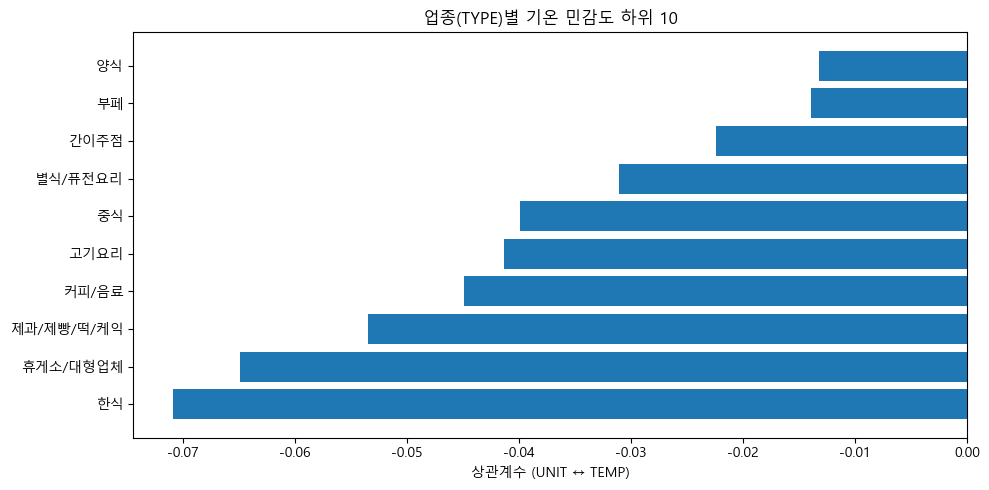

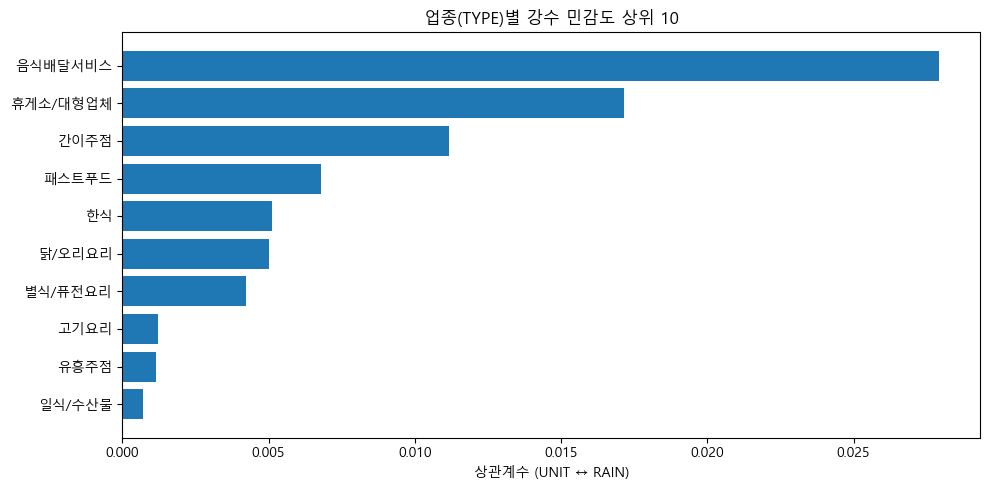

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# -----------------------------
# 0) 한글 폰트 설정 (깨짐 방지)
# -----------------------------
def set_korean_font():
    # 많이 쓰는 한글 폰트 후보 (환경에 따라 존재 여부가 다름)
    candidates = [
        "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",   # Linux (Nanum)
        "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf",
        "C:/Windows/Fonts/malgun.ttf",                        # Windows (맑은 고딕)
        "/System/Library/Fonts/AppleGothic.ttf",              # macOS
    ]

    font_path = None
    for p in candidates:
        if os.path.exists(p):
            font_path = p
            break

    if font_path:
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rcParams["font.family"] = font_name
    else:
        # 폰트 파일을 못 찾으면, 설치된 폰트 목록에서 한글 폰트가 있는지 시도
        installed = [f.name for f in fm.fontManager.ttflist]
        for name in ["NanumGothic", "NanumBarunGothic", "Malgun Gothic", "AppleGothic"]:
            if name in installed:
                plt.rcParams["font.family"] = name
                break

    # 마이너스 기호 깨짐 방지
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

# -----------------------------
# 1) 데이터 로드
# -----------------------------
df = pd.read_csv("C:/data/SUWON_FOOD_DATA_TABLE.csv")

# -----------------------------
# 2) TYPE별 날씨 민감도(상관계수) 계산
#    - 표본 적은 TYPE는 제외(노이즈 방지)
# -----------------------------
min_n = 1000
rows = []

for t, g in df.groupby("TYPE"):
    if len(g) < min_n:
        continue
    rows.append({
        "TYPE": t,
        "N": len(g),
        "TEMP_CORR(UNIT,TEMP)": g["UNIT"].corr(g["TEMP"]),
        "RAIN_CORR(UNIT,RAIN)": g["UNIT"].corr(g["RAIN"]),
    })

sens = pd.DataFrame(rows)

# 보기 좋게 정렬: TEMP 민감도 높은 순
sens_sorted = sens.sort_values("TEMP_CORR(UNIT,TEMP)", ascending=False).reset_index(drop=True)

# -----------------------------
# 3) 표 출력(콘솔) + CSV 저장(엑셀 호환)
# -----------------------------
print("=== TYPE별 날씨 민감도 (상위 15개: TEMP 기준) ===")
print(sens_sorted.head(15).to_string(index=False))

output_csv = "C:/data/TYPE_날씨민감도_상관계수.csv"
sens_sorted.to_csv(output_csv, index=False, encoding="utf-8-sig")
print("\n저장 완료:", output_csv)

# -----------------------------
# 4) 그래프 (한글 정상 표시)
# -----------------------------
top10 = sens_sorted.head(10)
bottom10 = sens_sorted.tail(10)

# (A) TEMP 민감도 상위 10
plt.figure(figsize=(10, 5))
plt.barh(top10["TYPE"], top10["TEMP_CORR(UNIT,TEMP)"])
plt.gca().invert_yaxis()
plt.xlabel("상관계수 (UNIT ↔ TEMP)")
plt.title("업종(TYPE)별 기온 민감도 상위 10")
plt.tight_layout()
plt.show()

# (B) TEMP 민감도 하위 10
plt.figure(figsize=(10, 5))
plt.barh(bottom10["TYPE"], bottom10["TEMP_CORR(UNIT,TEMP)"])
plt.gca().invert_yaxis()
plt.xlabel("상관계수 (UNIT ↔ TEMP)")
plt.title("업종(TYPE)별 기온 민감도 하위 10")
plt.tight_layout()
plt.show()

# (C) RAIN 민감도 상위 10 (참고)
rain_top10 = sens.sort_values("RAIN_CORR(UNIT,RAIN)", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.barh(rain_top10["TYPE"], rain_top10["RAIN_CORR(UNIT,RAIN)"])
plt.gca().invert_yaxis()
plt.xlabel("상관계수 (UNIT ↔ RAIN)")
plt.title("업종(TYPE)별 강수 민감도 상위 10")
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import numpy as np

# 1. 데이터 로드
df = pd.read_csv("C:/data/SUWON_FOOD_DATA_TABLE.csv")

# 2. TYPE별 날씨 상관관계 계산
rows = []
min_n = 1000  # 표본 수 기준

for t, g in df.groupby("TYPE"):
    if len(g) < min_n:
        continue

    temp_corr = g["UNIT"].corr(g["TEMP"])
    rain_corr = g["UNIT"].corr(g["RAIN"])

    rows.append({
        "TYPE": t,
        "N": len(g),
        "TEMP_CORR": temp_corr,
        "RAIN_CORR": rain_corr
    })

sens = pd.DataFrame(rows)

# 3. 날씨 민감도 점수화
sens["WEATHER_SCORE"] = (
    0.7 * sens["TEMP_CORR"].abs()
  + 0.3 * sens["RAIN_CORR"].abs()
) * 100

# 4. 점수 기준 정렬
sens = sens.sort_values("WEATHER_SCORE", ascending=False).reset_index(drop=True)

# 5. 결과 확인
print("=== 업종별 날씨 민감도 점수 TOP 15 ===")
print(sens[["TYPE", "WEATHER_SCORE", "TEMP_CORR", "RAIN_CORR", "N"]].head(15))

# 6. CSV 저장 (엑셀용)
output_path = "C:/data/업종별_날씨민감도_점수.csv"
sens.to_csv(output_path, index=False, encoding="utf-8-sig")

print("\n저장 완료:", output_path)


=== 업종별 날씨 민감도 점수 TOP 15 ===
          TYPE  WEATHER_SCORE  TEMP_CORR  RAIN_CORR       N
0           한식       5.115740  -0.070889   0.005118  102256
1     휴게소/대형업체       5.055774  -0.064874   0.017153    9812
2   제과/제빵/떡/케익       3.979627  -0.053461  -0.007911   92250
3        커피/음료       3.163157  -0.044930   0.000601  101513
4      음식배달서비스       3.089903   0.032174   0.027924    6891
5         고기요리       2.931172  -0.041354   0.001212   84140
6           중식       2.827927  -0.039896  -0.001173   73650
7      별식/퓨전요리       2.301418  -0.031059   0.004244   79618
8         간이주점       1.904072  -0.022413   0.011171   79528
9         유흥주점       1.163296   0.016124   0.001153   30102
10          부페       1.039831  -0.013912  -0.002199   33490
11       패스트푸드       1.022426  -0.011702   0.006776   83166
12          양식       0.935277  -0.013237  -0.000289   48537
13          분식       0.915616  -0.013062   0.000042   89882
14      닭/오리요리       0.887170  -0.010530   0.005003   82195

저장 완료: C:/

=== TYPE별 날씨 민감도 (상위 10: TEMP_SENS 기준) ===
          TYPE  TEMP_CORR  RAIN_CORR       N
14          한식  -0.070889   0.005118  102256
15    휴게소/대형업체  -0.064874   0.017153    9812
10  제과/제빵/떡/케익  -0.053461  -0.007911   92250
12       커피/음료  -0.044930   0.000601  101513
1         고기요리  -0.041354   0.001212   84140
11          중식  -0.039896  -0.001173   73650
8      음식배달서비스   0.032174   0.027924    6891
3      별식/퓨전요리  -0.031059   0.004244   79618
0         간이주점  -0.022413   0.011171   79528
7         유흥주점   0.016124   0.001153   30102


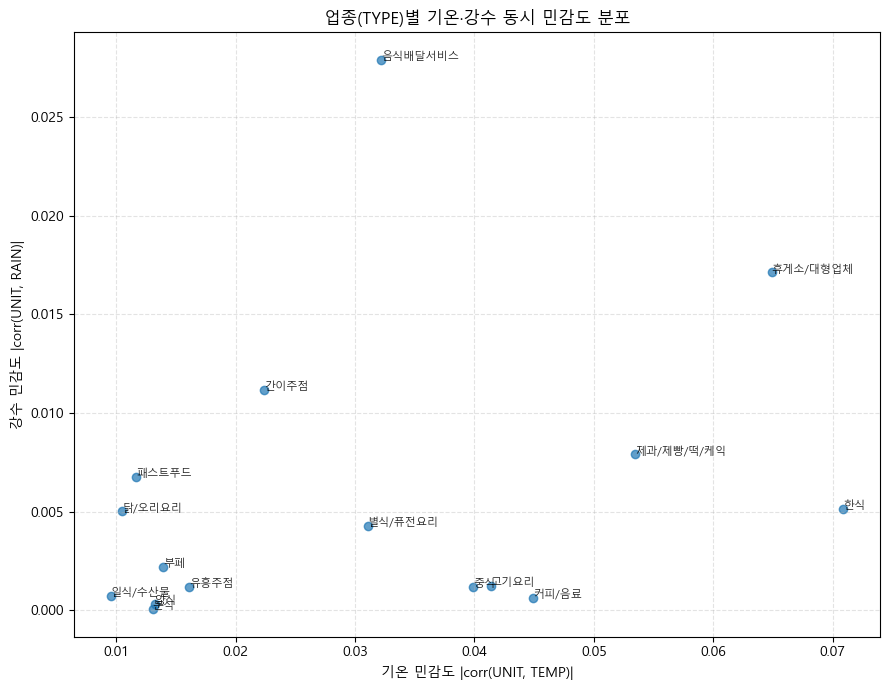

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# -----------------------------
# 0) 한글 폰트 설정 (깨짐 방지)
# -----------------------------
def set_korean_font():
    candidates = [
        "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",  # Linux (Nanum)
        "C:/Windows/Fonts/malgun.ttf",                       # Windows (맑은 고딕)
        "/System/Library/Fonts/AppleGothic.ttf",             # macOS
    ]
    for p in candidates:
        if os.path.exists(p):
            plt.rcParams["font.family"] = fm.FontProperties(fname=p).get_name()
            break
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

# -----------------------------
# 1) 데이터 로드
# -----------------------------
df = pd.read_csv("C:/data/SUWON_FOOD_DATA_TABLE.csv")

# -----------------------------
# 2) TYPE별 기온/강수 민감도 계산
#    - UNIT 기준 corr(UNIT, TEMP), corr(UNIT, RAIN)
#    - 표본 수 작은 TYPE는 제외(노이즈 방지)
# -----------------------------
min_n = 1000
rows = []

for t, g in df.groupby("TYPE"):
    if len(g) < min_n:
        continue

    rows.append({
        "TYPE": t,
        "N": len(g),
        "TEMP_CORR": g["UNIT"].corr(g["TEMP"]),
        "RAIN_CORR": g["UNIT"].corr(g["RAIN"]),
    })

sens = pd.DataFrame(rows)

# 민감도는 방향보다 "크기"가 중요하니 절대값 사용
sens["TEMP_SENS"] = sens["TEMP_CORR"].abs()
sens["RAIN_SENS"] = sens["RAIN_CORR"].abs()

# -----------------------------
# 3) (선택) 결과 표 확인
# -----------------------------
print("=== TYPE별 날씨 민감도 (상위 10: TEMP_SENS 기준) ===")
print(sens.sort_values("TEMP_SENS", ascending=False)[["TYPE","TEMP_CORR","RAIN_CORR","N"]].head(10))

# -----------------------------
# 4) 산점도 그래프: 기온 민감도 vs 강수 민감도
# -----------------------------
plt.figure(figsize=(9, 7))
plt.scatter(sens["TEMP_SENS"], sens["RAIN_SENS"], alpha=0.7)

# 업종명 라벨 표시 (업종 수가 많으면 글씨가 겹칠 수 있음)
for _, r in sens.iterrows():
    plt.text(r["TEMP_SENS"], r["RAIN_SENS"], r["TYPE"], fontsize=8, alpha=0.85)

plt.xlabel("기온 민감도 |corr(UNIT, TEMP)|")
plt.ylabel("강수 민감도 |corr(UNIT, RAIN)|")
plt.title("업종(TYPE)별 기온·강수 동시 민감도 분포")
plt.grid(True, linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()


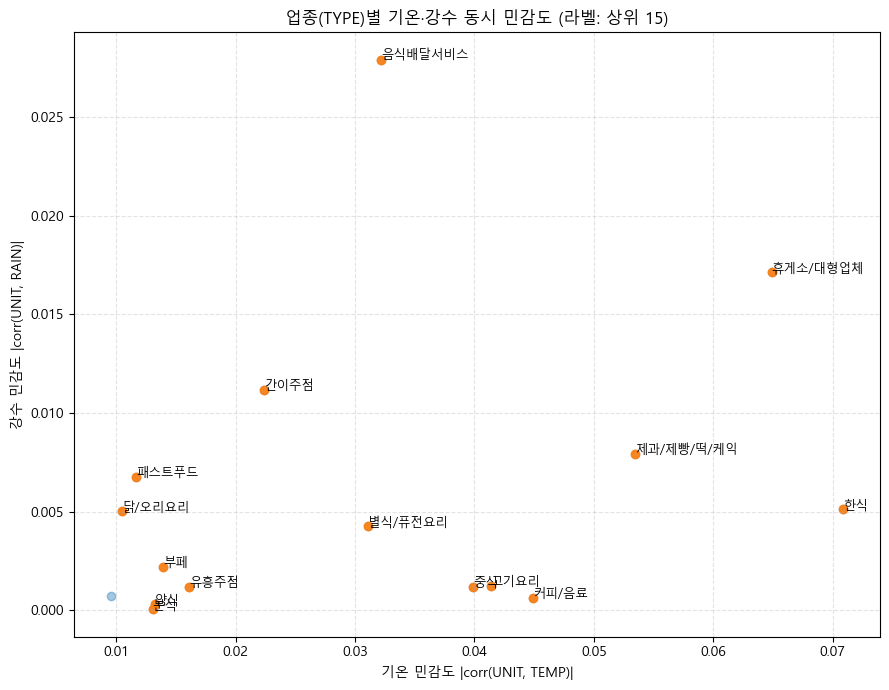

In [5]:
topN = 15
label_df = sens.sort_values(["TEMP_SENS","RAIN_SENS"], ascending=False).head(topN)

plt.figure(figsize=(9, 7))
plt.scatter(sens["TEMP_SENS"], sens["RAIN_SENS"], alpha=0.4)
plt.scatter(label_df["TEMP_SENS"], label_df["RAIN_SENS"], alpha=0.9)

for _, r in label_df.iterrows():
    plt.text(r["TEMP_SENS"], r["RAIN_SENS"], r["TYPE"], fontsize=9)

plt.xlabel("기온 민감도 |corr(UNIT, TEMP)|")
plt.ylabel("강수 민감도 |corr(UNIT, RAIN)|")
plt.title(f"업종(TYPE)별 기온·강수 동시 민감도 (라벨: 상위 {topN})")
plt.grid(True, linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()

한식 기온 민감도 순위: 1위, 값: 0.0709


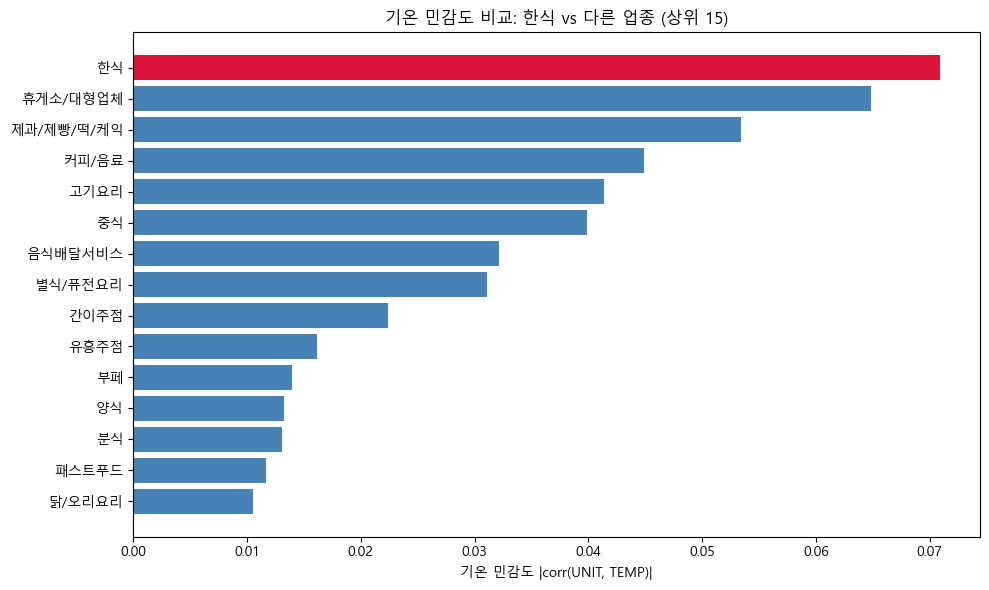

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# -----------------------------
# 0) 한글 폰트 설정 (깨짐 방지)
# -----------------------------
def set_korean_font():
    candidates = [
        "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",  # Linux
        "C:/Windows/Fonts/malgun.ttf",                       # Windows
        "/System/Library/Fonts/AppleGothic.ttf",             # macOS
    ]
    for p in candidates:
        if os.path.exists(p):
            plt.rcParams["font.family"] = fm.FontProperties(fname=p).get_name()
            break
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

# -----------------------------
# 1) 데이터 로드
# -----------------------------
df = pd.read_csv("C:/data/SUWON_FOOD_DATA_TABLE.csv")

# -----------------------------
# 2) 업종(TYPE)별 기온 민감도 계산
#    - 민감도 = |corr(UNIT, TEMP)|
#    - 표본 적은 업종은 제외
# -----------------------------
min_n = 1000
rows = []

for t, g in df.groupby("TYPE"):
    if len(g) < min_n:
        continue

    temp_corr = g["UNIT"].corr(g["TEMP"])
    rows.append({
        "TYPE": t,
        "TEMP_SENS": abs(temp_corr),
        "N": len(g)
    })

sens = pd.DataFrame(rows).sort_values("TEMP_SENS", ascending=False).reset_index(drop=True)

# -----------------------------
# 3) 한식 순위/값 확인 (옵션)
# -----------------------------
hansik_row = sens[sens["TYPE"] == "한식"]
if len(hansik_row) > 0:
    hansik_rank = int(hansik_row.index[0]) + 1
    hansik_value = float(hansik_row["TEMP_SENS"].iloc[0])
    print(f"한식 기온 민감도 순위: {hansik_rank}위, 값: {hansik_value:.4f}")
else:
    print("'한식' TYPE을 찾지 못했습니다. TYPE 값 확인 필요.")

# -----------------------------
# 4) 상위 15개 업종 그래프 (한식 강조)
# -----------------------------
top15 = sens.head(15).copy()

# 한식만 색 강조
colors = ["crimson" if t == "한식" else "steelblue" for t in top15["TYPE"]]

plt.figure(figsize=(10, 6))
plt.barh(top15["TYPE"], top15["TEMP_SENS"], color=colors)
plt.gca().invert_yaxis()
plt.xlabel("기온 민감도 |corr(UNIT, TEMP)|")
plt.title("기온 민감도 비교: 한식 vs 다른 업종 (상위 15)")
plt.tight_layout()
plt.show()


       TYPE  TEMP_SENS  RAIN_SENS       N
0        한식   0.070889   0.005118  102256
1  휴게소/대형업체   0.064874   0.017153    9812
2   음식배달서비스   0.032174   0.027924    6891


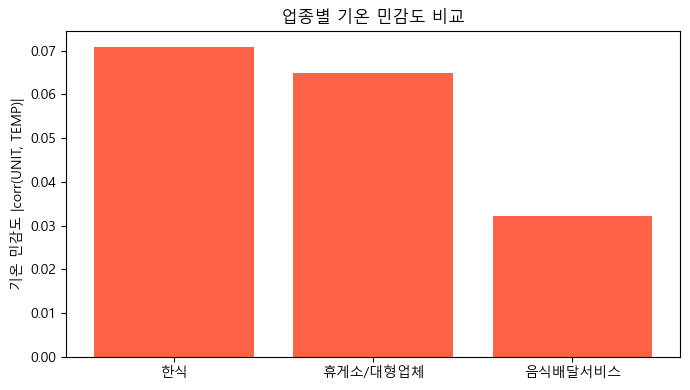

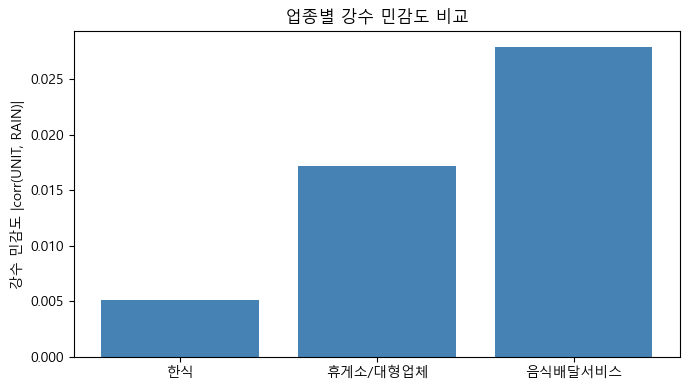

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# -----------------------------
# 0) 한글 폰트 설정
# -----------------------------
def set_korean_font():
    candidates = [
        "/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
        "C:/Windows/Fonts/malgun.ttf",
        "/System/Library/Fonts/AppleGothic.ttf",
    ]
    for p in candidates:
        if os.path.exists(p):
            plt.rcParams["font.family"] = fm.FontProperties(fname=p).get_name()
            break
    plt.rcParams["axes.unicode_minus"] = False

set_korean_font()

# -----------------------------
# 1) 데이터 로드
# -----------------------------
df = pd.read_csv("C:/data/SUWON_FOOD_DATA_TABLE.csv")

# -----------------------------
# 2) 분석 대상 업종
# -----------------------------
target_types = ["한식", "휴게소/대형업체", "음식배달서비스"]

rows = []
for t in target_types:
    g = df[df["TYPE"] == t]
    rows.append({
        "TYPE": t,
        "TEMP_SENS": abs(g["UNIT"].corr(g["TEMP"])),
        "RAIN_SENS": abs(g["UNIT"].corr(g["RAIN"])),
        "N": len(g)
    })

sens_df = pd.DataFrame(rows)
print(sens_df)

# -----------------------------
# 3) 그래프 1: 기온 민감도
# -----------------------------
plt.figure(figsize=(7, 4))
plt.bar(sens_df["TYPE"], sens_df["TEMP_SENS"], color="tomato")
plt.ylabel("기온 민감도 |corr(UNIT, TEMP)|")
plt.title("업종별 기온 민감도 비교")
plt.tight_layout()
plt.show()

# -----------------------------
# 4) 그래프 2: 강수 민감도
# -----------------------------
plt.figure(figsize=(7, 4))
plt.bar(sens_df["TYPE"], sens_df["RAIN_SENS"], color="steelblue")
plt.ylabel("강수 민감도 |corr(UNIT, RAIN)|")
plt.title("업종별 강수 민감도 비교")
plt.tight_layout()
plt.show()


In [13]:
# -*- coding: utf-8 -*-
"""
[PATCHED] 한식/음식배달서비스: 일자(TA_YMD) x 항목요약 시간대(HOUR=01~10) UNIT 예측
- 항목요약 시간대 사용 :contentReference[oaicite:0]{index=0}
- 기상청 OpenAPI(동네예보)로 TEMP/RAIN 수집 후 슬롯(01~10) 집계
- NaN 방지 로직(핵심 패치) 추가:
  1) 날씨 merge 후 TEMP/RAIN 결측 채움
  2) feature_cols 전체에 대해 마지막 안전장치(base.fillna(0))
  3) 학습(train_df)에서도 동일하게 결측 방어

"""

import os
import re
import joblib
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from dotenv import load_dotenv
load_dotenv('./../01_python/.env')
SERVICE_KEY = os.getenv('RAIN_ID') 

# =========================
# 0) 사용자 설정
# =========================
DATA_PATH = "C:/data/SUWON_FOOD_DATA_TABLE.csv"

KMA_SERVICE_KEY = SERVICE_KEY

# 수원 동네예보 격자 (필요시 수정)
KMA_NX = 60
KMA_NY = 121

TARGET_TYPES = ["한식", "음식배달서비스"]

MODEL_DIR = "/mnt/data/models_unit_by_slot"
os.makedirs(MODEL_DIR, exist_ok=True)

# =========================
# 1) 항목요약 시간대(01~10) 변환
# =========================
def hour_to_slot_code(hour_0_23: int) -> int:
    """0~23시 -> 항목요약 HOUR 코드(1~10)"""
    if 0 <= hour_0_23 <= 6:
        return 1
    if 7 <= hour_0_23 <= 8:
        return 2
    if 9 <= hour_0_23 <= 10:
        return 3
    if 11 <= hour_0_23 <= 12:
        return 4
    if 13 <= hour_0_23 <= 14:
        return 5
    if 15 <= hour_0_23 <= 16:
        return 6
    if 17 <= hour_0_23 <= 18:
        return 7
    if 19 <= hour_0_23 <= 20:
        return 8
    if 21 <= hour_0_23 <= 22:
        return 9
    if hour_0_23 == 23:
        return 10
    raise ValueError("hour must be 0~23")


# =========================
# 2) 공휴일 feature (옵션)
# =========================
def add_holiday_feature(df: pd.DataFrame, date_col: str = "date") -> pd.DataFrame:
    df = df.copy()
    df["is_holiday"] = 0
    try:
        import holidays
        kr = holidays.KR()
        df["is_holiday"] = df[date_col].dt.date.map(lambda d: 1 if d in kr else 0).astype(int)
    except Exception:
        pass
    return df


# =========================
# 3) 기상청 OpenAPI (동네예보)
# =========================
KMA_BASE_URL = "https://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"

def _kma_request(params: dict) -> dict:
    params = params.copy()
    params.update({"serviceKey": KMA_SERVICE_KEY, "dataType": "JSON"})
    r = requests.get(KMA_BASE_URL, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def _parse_kma_items(j: dict) -> pd.DataFrame:
    items = j["response"]["body"]["items"]["item"]
    return pd.DataFrame(items)

def fetch_kma_forecast_hourly(start_date: str, end_date: str, nx: int, ny: int) -> pd.DataFrame:
    """
    동네예보에서 시간별 예보를 가져와 dt별 temp/rain_mm/rain_yn 생성
    start_date/end_date: 'YYYY-MM-DD'
    """
    now = datetime.now()
    base_date = now.strftime("%Y%m%d")
    base_times = ["0200", "0500", "0800", "1100", "1400", "1700", "2000", "2300"]
    cur_hhmm = now.strftime("%H%M")

    base_time = None
    for bt in reversed(base_times):
        if cur_hhmm >= bt:
            base_time = bt
            break
    if base_time is None:
        base_time = "2300"
        base_date = (now - timedelta(days=1)).strftime("%Y%m%d")

    params = {
        "numOfRows": 5000,
        "pageNo": 1,
        "base_date": base_date,
        "base_time": base_time,
        "nx": nx,
        "ny": ny,
    }

    j = _kma_request(params)
    raw = _parse_kma_items(j)

    want = {"TMP", "PCP", "PTY"}
    raw = raw[raw["category"].isin(want)].copy()

    raw["fcstDate"] = raw["fcstDate"].astype(str)
    raw["fcstTime"] = raw["fcstTime"].astype(str).str.zfill(4)
    raw["dt"] = pd.to_datetime(raw["fcstDate"] + raw["fcstTime"], format="%Y%m%d%H%M")

    pv = raw.pivot_table(index="dt", columns="category", values="fcstValue", aggfunc="last").reset_index()

    # 기온
    pv["temp"] = pd.to_numeric(pv.get("TMP"), errors="coerce")

    # 강수(PCP 문자열 파싱)
    def parse_pcp(x):
        if pd.isna(x):
            return np.nan
        x = str(x).strip()
        if x in ["강수없음", "0", "0.0", "0mm", "0.0mm", "-"]:
            return 0.0
        m = re.findall(r"[\d.]+", x)
        return float(m[0]) if m else np.nan

    pv["rain_mm"] = pv["PCP"].apply(parse_pcp) if "PCP" in pv.columns else np.nan

    # PTY: 0=없음, 1=비, 2=비/눈, 3=눈, 4=소나기
    if "PTY" in pv.columns:
        pty = pd.to_numeric(pv["PTY"], errors="coerce").fillna(0)
        pv["rain_yn"] = (pty > 0).astype(int)
    else:
        pv["rain_yn"] = (pv["rain_mm"].fillna(0) > 0).astype(int)

    s = pd.to_datetime(start_date)
    e = pd.to_datetime(end_date) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    pv = pv[(pv["dt"] >= s) & (pv["dt"] <= e)].copy()

    return pv[["dt", "temp", "rain_mm", "rain_yn"]].sort_values("dt").reset_index(drop=True)

def weather_hourly_to_slots(weather_hourly: pd.DataFrame) -> pd.DataFrame:
    """시간별(dt) 날씨 -> 항목요약 슬롯(HOUR=1~10) 집계"""
    w = weather_hourly.copy()
    w["TA_YMD"] = w["dt"].dt.strftime("%Y%m%d").astype(int)
    w["hour"] = w["dt"].dt.hour
    w["HOUR"] = w["hour"].apply(hour_to_slot_code)

    agg = (
        w.groupby(["TA_YMD", "HOUR"], as_index=False)
         .agg(
            TEMP=("temp", "mean"),
            RAIN=("rain_mm", "sum"),
            RAIN_YN=("rain_yn", "max"),
         )
    )
    return agg[["TA_YMD", "HOUR", "TEMP", "RAIN"]].sort_values(["TA_YMD", "HOUR"]).reset_index(drop=True)


# =========================
# 4) 학습 데이터 생성
# =========================
def build_training_frame(data_path: str, target_types: list[str]) -> pd.DataFrame:
    raw = pd.read_csv(data_path)
    raw = raw[raw["TYPE"].isin(target_types)].copy()

    raw["TA_YMD"] = raw["TA_YMD"].astype(int)
    raw["date"] = pd.to_datetime(raw["TA_YMD"].astype(str), format="%Y%m%d")

    # (일자, 슬롯, 업종) UNIT 합산
    y = (
        raw.groupby(["TA_YMD", "HOUR", "TYPE"], as_index=False)
           .agg(UNIT=("UNIT", "sum"))
    )
    y["date"] = pd.to_datetime(y["TA_YMD"].astype(str), format="%Y%m%d")

    # (일자, 슬롯) 날씨는 평균
    w = (
        raw.groupby(["TA_YMD", "HOUR"], as_index=False)
           .agg(TEMP=("TEMP", "mean"), RAIN=("RAIN", "mean"))
    )

    df = y.merge(w, on=["TA_YMD", "HOUR"], how="left")

    # 캘린더 feature
    df["dow"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
    df = add_holiday_feature(df, date_col="date")

    # ---------- NaN 방어(학습) ----------
    df["TEMP"] = df["TEMP"].fillna(df["TEMP"].median())
    df["RAIN"] = df["RAIN"].fillna(0.0)

    # 캘린더 feature 결측 방어(혹시 모를 케이스)
    for c in ["HOUR", "dow", "month", "day", "weekofyear", "is_holiday"]:
        df[c] = df[c].fillna(0).astype(int)

    return df


# =========================
# 5) 업종별 모델 학습
# =========================
FEATURE_COLS = ["HOUR", "dow", "month", "day", "weekofyear", "is_holiday", "TEMP", "RAIN"]

def train_models(train_df: pd.DataFrame, model_dir: str) -> None:
    # ---------- NaN 방어(학습 입력 직전) ----------
    train_df = train_df.copy()
    train_df["TEMP"] = train_df["TEMP"].fillna(train_df["TEMP"].median())
    train_df["RAIN"] = train_df["RAIN"].fillna(0.0)
    train_df[FEATURE_COLS] = train_df[FEATURE_COLS].fillna(0)

    for t in TARGET_TYPES:
        sub = train_df[train_df["TYPE"] == t].copy()
        X = sub[FEATURE_COLS]
        y = sub["UNIT"]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        model = RandomForestRegressor(
            n_estimators=500,
            random_state=42,
            n_jobs=-1,
            min_samples_leaf=2
        )
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        rmse = mean_squared_error(y_test, pred, squared=False)
        print(f"[{t}] MAE={mae:,.2f}  RMSE={rmse:,.2f}  n={len(sub):,}")

        joblib.dump(
            {"model": model, "feature_cols": FEATURE_COLS},
            os.path.join(model_dir, f"rf_unit_{t}.joblib")
        )


# =========================
# 6) 미래 예측 프레임 생성 (일자 x 슬롯 01~10)
# =========================
def make_future_frame(start_date: str, end_date: str) -> pd.DataFrame:
    s = pd.to_datetime(start_date)
    e = pd.to_datetime(end_date)
    days = pd.date_range(s, e, freq="D")

    rows = []
    for d in days:
        for slot in range(1, 11):  # 항목요약 슬롯 01~10
            rows.append({"date": d, "TA_YMD": int(d.strftime("%Y%m%d")), "HOUR": slot})

    base = pd.DataFrame(rows)
    base["dow"] = base["date"].dt.dayofweek
    base["month"] = base["date"].dt.month
    base["day"] = base["date"].dt.day
    base["weekofyear"] = base["date"].dt.isocalendar().week.astype(int)
    base = add_holiday_feature(base, date_col="date")

    # 결측 방어
    for c in ["HOUR", "dow", "month", "day", "weekofyear", "is_holiday"]:
        base[c] = base[c].fillna(0).astype(int)

    return base


def predict_future_unit(start_date: str, end_date: str, model_dir: str) -> pd.DataFrame:
    # 1) 미래 달력 프레임
    base = make_future_frame(start_date, end_date)

    # 2) 기상청 예보(시간별) -> 항목요약 슬롯 집계
    hourly = fetch_kma_forecast_hourly(start_date, end_date, nx=KMA_NX, ny=KMA_NY)
    w_slot = weather_hourly_to_slots(hourly)

    # 3) merge
    base = base.merge(w_slot, on=["TA_YMD", "HOUR"], how="left")

    # ---------- NaN 방어(예측) 핵심 ----------
    # TEMP가 통째로 NaN이면 median 계산도 NaN일 수 있어서 0으로도 한번 더 방어
    temp_med = base["TEMP"].median()
    if pd.isna(temp_med):
        temp_med = 0.0

    base["TEMP"] = base["TEMP"].fillna(temp_med)
    base["RAIN"] = base["RAIN"].fillna(0.0)

    # 마지막 안전장치: feature 전체 NaN 제거
    base[FEATURE_COLS] = base[FEATURE_COLS].fillna(0)

    # (디버그) NaN 남아있으면 바로 예외
    if base[FEATURE_COLS].isna().any().any():
        raise ValueError("NaN still exists in model input FEATURES")

    # 4) 업종별 예측
    out = []
    for t in TARGET_TYPES:
        pack = joblib.load(os.path.join(model_dir, f"rf_unit_{t}.joblib"))
        model = pack["model"]
        feature_cols = pack["feature_cols"]

        X = base[feature_cols]
        pred = model.predict(X)

        tmp = base[["TA_YMD", "HOUR", "TEMP", "RAIN"]].copy()
        tmp["TYPE"] = t
        tmp["PRED_UNIT"] = np.maximum(pred, 0)
        out.append(tmp)

    pred_df = pd.concat(out, ignore_index=True)
    return pred_df.sort_values(["TYPE", "TA_YMD", "HOUR"]).reset_index(drop=True)


# =========================
# 7) 실행 예시
# =========================
if __name__ == "__main__":
    # 학습
    train_df = build_training_frame(DATA_PATH, TARGET_TYPES)
    train_models(train_df, MODEL_DIR)

    # 예측(예: 오늘~+3일 정도로 설정 권장: 동네예보 범위 때문에)
    pred = predict_future_unit("2025-12-26", "2025-12-29", MODEL_DIR)

    # 저장
    out_path = "C:/data/pred_unit_by_slot_hansik_delivery.csv"
    pred.to_csv(out_path, index=False, encoding="utf-8-sig")
    print("saved:", out_path)



[한식] MAE=34,419.92  RMSE=56,378.59  n=10,350
[음식배달서비스] MAE=7,564.25  RMSE=12,017.03  n=6,504
saved: C:/data/pred_unit_by_slot_hansik_delivery.csv
